Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [82]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [83]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [84]:
# Note: Here I have used my Google drive path, Please change it to your location to unzip and test train paths and class imbalance paths.
import shutil
shutil.unpack_archive("/content/drive/MyDrive/CNN_assignment.zip", "/content/drive/MyDrive/CNN Assignment")


In [85]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Data Reading/Data Understanding 

In [86]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [87]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [88]:
batch_size = 32
img_height = 180
img_width = 180

In [89]:

# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

Use 80% of the images for training, and 20% for validation.

In [90]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [91]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [92]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

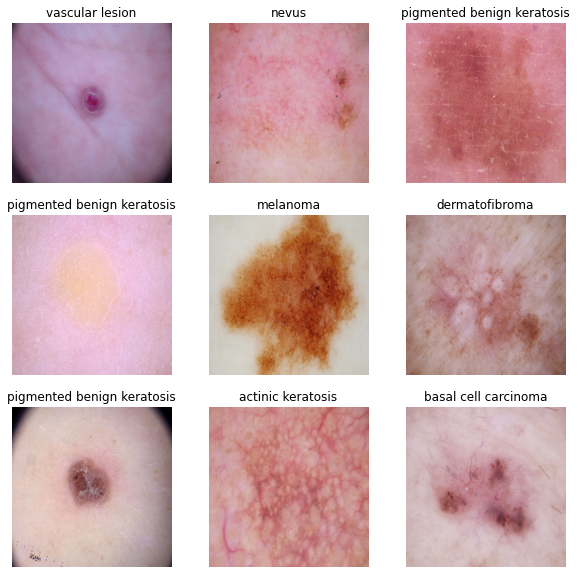

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [94]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [95]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)




### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [96]:
### Your code goes here
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [97]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [98]:
# View the summary of all layers
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 20, 20, 32)       

### Train the model

In [99]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 21s 112ms/step - loss: 1.8971 - accuracy: 0.2980 - val_loss: 1.6679 - val_accuracy: 0.3803
Epoch 2/20
56/56 [==============================] - 3s 49ms/step - loss: 1.5816 - accuracy: 0.4431 - val_loss: 1.4839 - val_accuracy: 0.4765
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 1.4716 - accuracy: 0.4682 - val_loss: 1.4600 - val_accuracy: 0.5078
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.3622 - accuracy: 0.5212 - val_loss: 1.3609 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 3s 47ms/step - loss: 1.2707 - accuracy: 0.5296 - val_loss: 1.3289 - val_accuracy: 0.5369
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.2141 - accuracy: 0.5647 - val_loss: 1.5080 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 3s 48ms/step - loss: 1.1938 - accuracy: 0.5792 - val_loss: 1.3965 - val_accuracy: 0.5324
Epoch 8/20


### Visualizing training results

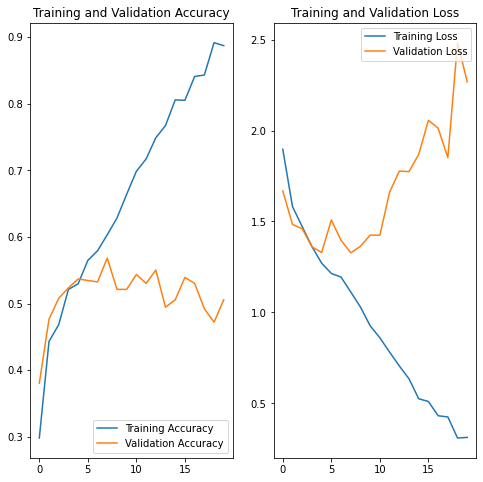

In [100]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

- training accuracy : 86
- Validation Accuracy: 51
- From the above figure it is clear that it is over fitting, to avoid overfitting we can use data augmentaion

## data augmentaion

In [101]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)




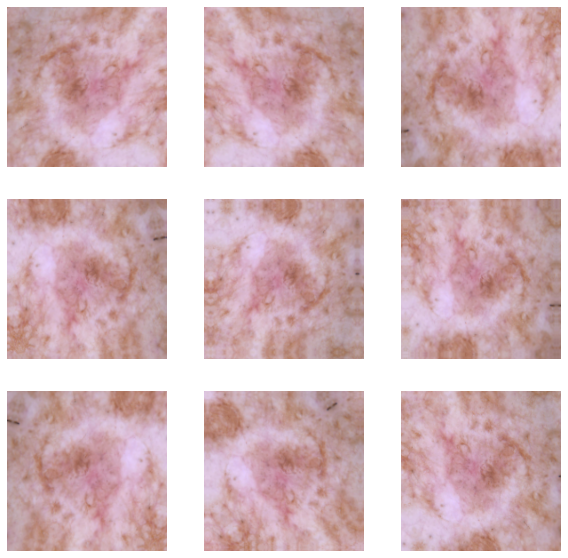

In [102]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")



### Todo:
### Create the model, compile and train the model


In [103]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])




### Compiling the model

In [104]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 45, 45, 64)      

### Training the model

In [105]:
## Your code goes here, note: train your model for 20 epochs

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 52ms/step - loss: 2.1545 - accuracy: 0.1981 - val_loss: 2.0208 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 3s 50ms/step - loss: 1.9706 - accuracy: 0.2623 - val_loss: 1.8161 - val_accuracy: 0.3826
Epoch 3/20
56/56 [==============================] - 3s 50ms/step - loss: 1.7566 - accuracy: 0.3655 - val_loss: 1.5568 - val_accuracy: 0.4564
Epoch 4/20
56/56 [==============================] - 3s 51ms/step - loss: 1.5438 - accuracy: 0.4660 - val_loss: 1.5473 - val_accuracy: 0.4810
Epoch 5/20
56/56 [==============================] - 3s 50ms/step - loss: 1.4822 - accuracy: 0.4799 - val_loss: 1.4167 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 3s 49ms/step - loss: 1.4168 - accuracy: 0.4972 - val_loss: 1.4419 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 3s 50ms/step - loss: 1.3433 - accuracy: 0.5240 - val_loss: 1.3919 - val_accuracy: 0.5280
Epoch 8/20
56

### Visualizing the results

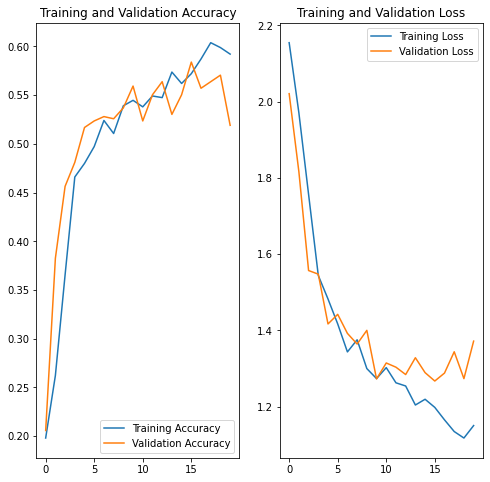

In [106]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
- There is an iprovement in the model but still need to improve
- Training Accuracy : 60
- Validation Accuracy : 56

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [107]:
DIR = '/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
import os

# Your code goes here.

total = 0
for root, dirs, files in os.walk(DIR):
    total = len(files) 
    print(root , "------------" , total)


/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train ------------ 0
/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis ------------ 114
/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma ------------ 376
/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma ------------ 95
/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma ------------ 438
/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus ------------ 357
/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis ------------ 462
/content/drive/MyDrive/CNN Assignment/Skin can

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
 - seborrheic keratosis - 77
 - dermatofibroma - 95
#### - Which classes dominate the data in terms proportionate number of samples?
 - pigmented benign keratosis - 462
 - melanoma - 438
 - basal cell carcinoma - 376
 - nevus - 357


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [108]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [109]:
# Please change the path to your path here
path_to_training_dataset="/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names: 
  p = Augmentor.Pipeline(path_to_training_dataset+i)
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F23F06CAA50>: 100%|██████████| 500/500 [00:22<00:00, 21.84 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F23EEA8A7D0>: 100%|██████████| 500/500 [00:22<00:00, 22.70 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F23F0380F90>: 100%|██████████| 500/500 [00:22<00:00, 22.33 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F246868FE10>: 100%|██████████| 500/500 [01:59<00:00,  4.20 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F23EE7DF610>: 100%|██████████| 500/500 [01:37<00:00,  5.12 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F23F08B2250>: 100%|██████████| 500/500 [00:21<00:00, 22.75 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F23F099CE10>: 100%|██████████| 500/500 [00:51<00:00,  9.63 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F23F09E26D0>: 100%|██████████| 500/500 [00:22<00:00, 21.90 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F23ECC2FF10>: 100%|██████████| 500/500 [00:23<00:00, 21.36 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [110]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)


4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [111]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031430.jpg_0781a147-dee1-4f08-90f1-cadfdd69b25a.jpg',
 '/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030242.jpg_b7c39e5c-050f-42cc-816f-a035e4dfcdb6.jpg',
 '/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031609.jpg_86a17cc0-8bda-494e-af72-ec3658128673.jpg',
 '/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026765.jpg_a8fa1657-91f0-4a40-8f38-dc894679bb7e.jpg',
 '/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic kera

In [112]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [113]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [130]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])


In [115]:
df2['Label'].value_counts()

basal cell carcinoma          500
pigmented benign keratosis    500
squamous cell carcinoma       500
actinic keratosis             500
vascular lesion               500
seborrheic keratosis          500
melanoma                      500
nevus                         500
dermatofibroma                500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [116]:
DIR = '/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
import os

# Your code goes here.

total = 0
for root, dirs, files in os.walk(DIR):
    total = len(files) 
    print(root , "------------" , total)

/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train ------------ 0
/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis ------------ 114
/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output ------------ 500
/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma ------------ 376
/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output ------------ 500
/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma ------------ 95
/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output ------------ 500
/content/driv

#### **Todo**: Train the model on the data created using Augmentor

In [117]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [118]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset="training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [119]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
   subset="validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [120]:
## your code goes here
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255,  input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes,activation='softmax')
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [121]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [122]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 41, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 20, 20, 64)      

#### **Todo:**  Train your model

In [123]:
epochs = 20
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


169/169 [==============================] - 44s 247ms/step - loss: 1.9259 - accuracy: 0.2656 - val_loss: 1.5960 - val_accuracy: 0.3853
Epoch 2/20
169/169 [==============================] - 42s 240ms/step - loss: 1.5150 - accuracy: 0.4234 - val_loss: 1.4179 - val_accuracy: 0.4558
Epoch 3/20
169/169 [==============================] - 41s 234ms/step - loss: 1.3616 - accuracy: 0.4811 - val_loss: 1.2741 - val_accuracy: 0.5041
Epoch 4/20
169/169 [==============================] - 43s 245ms/step - loss: 1.2145 - accuracy: 0.5458 - val_loss: 1.1452 - val_accuracy: 0.5561
Epoch 5/20
169/169 [==============================] - 43s 247ms/step - loss: 1.0963 - accuracy: 0.5938 - val_loss: 1.1025 - val_accuracy: 0.5999
Epoch 6/20
169/169 [==============================] - 42s 244ms/step - loss: 0.9744 - accuracy: 0.6343 - val_loss: 1.0106 - val_accuracy: 0.6221
Epoch 7/20
169/169 [==============================] - 41s 236ms/step - loss: 0.8559 - accuracy: 0.6834 - val_loss: 0.9830 - val_accuracy: 0.6

#### **Todo:**  Visualize the model results

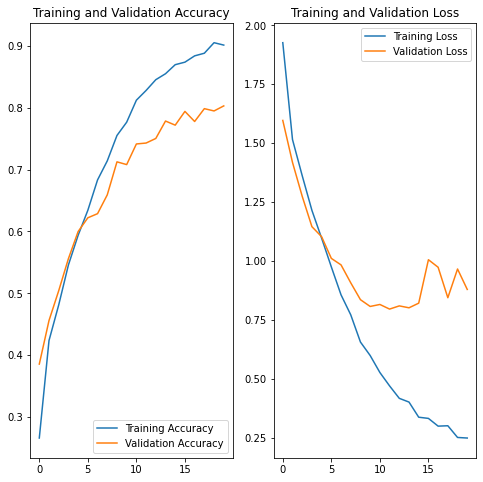

In [124]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- here we are get rid of Overfitting. Class rebalance helps to get rid of overfitting. Data Augmentaion helps to get rid of overfitting.
- Training Accuracy : 93 
- val_accuracy: 80

# Using 30 epochs and Batch normalization:



In [125]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255,  input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes,activation='softmax')
])


In [126]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_10 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 178, 178, 16)      448       
_________________________________________________________________
batch_normalization_9 (Batch (None, 178, 178, 16)      64        
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 87, 87, 32)        4640      
_________________________________________________________________
batch_normalization_10 (Batc (None, 87, 87, 32)        128       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 43, 43, 32)      

In [127]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


169/169 [==============================] - 44s 246ms/step - loss: 2.5370 - accuracy: 0.3012 - val_loss: 14.5465 - val_accuracy: 0.1433
Epoch 2/30
169/169 [==============================] - 52s 301ms/step - loss: 1.5803 - accuracy: 0.4082 - val_loss: 12.3655 - val_accuracy: 0.1886
Epoch 3/30
169/169 [==============================] - 54s 312ms/step - loss: 1.3182 - accuracy: 0.4907 - val_loss: 5.5168 - val_accuracy: 0.1915
Epoch 4/30
169/169 [==============================] - 54s 310ms/step - loss: 1.1771 - accuracy: 0.5395 - val_loss: 5.7704 - val_accuracy: 0.1492
Epoch 5/30
169/169 [==============================] - 48s 275ms/step - loss: 0.9700 - accuracy: 0.6155 - val_loss: 3.2080 - val_accuracy: 0.3378
Epoch 6/30
169/169 [==============================] - 46s 268ms/step - loss: 0.9208 - accuracy: 0.6473 - val_loss: 1.4200 - val_accuracy: 0.5449
Epoch 7/30
169/169 [==============================] - 47s 269ms/step - loss: 0.7866 - accuracy: 0.6971 - val_loss: 7.4123 - val_accuracy: 0

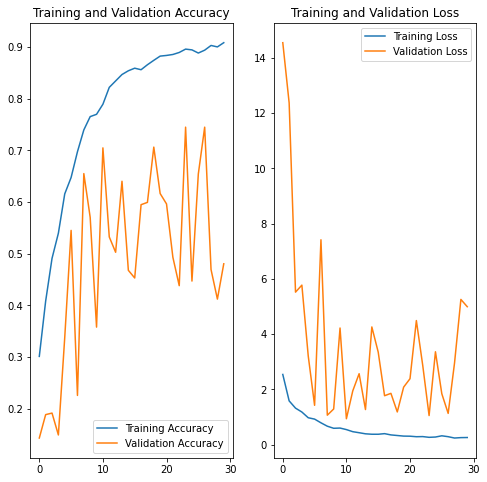

In [128]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [131]:
# Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
#### - it slighlty reduces the Overfitting but need some improvements with batch normalizations and epoch - 30. 
### - Training Accuracy : 90
### - val_accuracy: 58